<div>
    <h1 style="margin-top: 50px; font-size: 33px; text-align: center"> Homework 4 </h1>
    <br>
    <div style="font-weight:200; font-size: 20px; padding-bottom: 15px; width: 100%; text-align: center;">
        <right>Fabio Montello, Maria Luisa Croci, Eltaj Babanli</right>
        <br>
    </div>
    <hr>
</div>

<div>
    <h1 style="margin-top: -5px; font-size: 20px; text-align: center"> 1) Does basic house information reflect house' s description? </h1>
    <br>
</div>

### Scraping

In [1]:
import threading
import requests
import random
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import string
import libclust
import findspark
import pyspark
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup

In this section all the info about the houses are extract from the the following website https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1

In [ ]:
immobiliare = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1")
page = BeautifulSoup(immobiliare.text, "html5lib")
n = page.find_all("span", class_ = "pagination__label")
n = n[len(n) - 1] #last element
n = int(n.getText())
n #number of pages for taking the information

In [ ]:
links = []
notdw = []

In [ ]:
#The following function helps to make the scraping on each link
def getLinksFromPage(url):
    time.sleep(round(random.uniform(0.01, 0.4), 2))
    try:
        immobiliare = requests.get(url)
    except:
        notdw.append(url)
        return
    result = BeautifulSoup(immobiliare.text, "html5lib")
    x = result.find_all("p", class_ = "titolo")
    
    links.extend([item.find('a').get('href') for item in x if item.find('a').get('href').startswith("https://www.immobiliare.it/")])


In [ ]:
#in order to download faster the data we use threads that parallelize the procedure
threads = []
    
for i in range(n): #n
    url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=" + str(i + 1)
    t = threading.Thread(target=getLinksFromPage, args=(url,))
    threads.append(t)
    t.start()

In [ ]:
def areThreadsAlive(threads):
    for thread in threads:
        if(thread.isAlive() == True):
            return "Not finished yet"
    
    return "All threads are completed"

In [ ]:
#save a txt file with all the urls
linkfile = open('data/links.txt', 'w')
for link in links:
    linkfile.write("%s\n" % link)
linkfile.close()

In [ ]:
#extract the features for each apartment
#we consider only apartments that have all the features

feautures = []
descr = []
notdw = []
def getDataFromLinks(i, url):
    time.sleep(round(random.uniform(0.01, 0.4), 2))
    # Get the webpage
    try:
        info = requests.get(url)
    except:
        notdw.append(url)
        return
    info = BeautifulSoup(info.text, "html5lib")
    
    # Get the feauters needed
    feauts = info.find_all("div", class_ = "im-property__features")
    feautList = [item.find_all("span") for item in feauts]  
    listfeautures = info.find("ul", class_ = "features__list")
    try:
        
        price = info.find_all("li", class_ = "features__price")[0].find('span', recursive=False).getText()
        
        room = None
        bathroom = None
        floor = None
        surface = None

        for elem in listfeautures.findAll('li'):
            if str(elem).find("locali") != -1:
                room = elem.find('span').getText()

            elif (str(elem).find("bagni") != -1):
                bathroom = elem.find('span').getText()

            elif (str(elem).find("piano") != -1):
                floor = elem.find('abbr').getText()

            elif (str(elem).find("superficie") != -1):
                surface =  elem.find('span').getText()

            if((room is not None) and\
               (bathroom is not None) and\
               (floor is not None) and\
               (surface is not None)):
            # Get the description 
                descr.extend([[url, info.find_all("div", class_ = "description-text")[0] \
                       .getText()\
                       .replace('\n', ' ')\
                       .replace('                                              ', '')\
                       .replace('                      ','')\
                      ]])
                feautures.extend([[url, price, room, surface, bathroom, floor]])

    except:
        return

In [ ]:
threads = []

for i, url in enumerate(links):
    t = threading.Thread(target=getDataFromLinks, args=(i,url,))
    threads.append(t)
    t.start()

In [ ]:
#convert as data frame in order to save 
#matrix of the features
dfFe = pd.DataFrame(feautures, columns = ["Url", "Price", "Room", "Surface", "Bathroom", "Floor"])
#matrix of the descriptions
dfDe = pd.DataFrame(descr, columns = ["Url", "Descr"])

In [ ]:
dfFe.isnull().sum()

In [ ]:
dfFe.to_csv('data/feautures.csv', sep=',', na_rep='') 

In [ ]:
dfDe.to_csv('data/descriptions.csv', sep=',', na_rep='')

### Datasets

1) **INFORMATION**   
The dataframe "dfFe" is the matrix $m_{i,j} = value$ where $i=0,...,n$ is the announcement and $j$ is "price", "locali", "superficie", "bagni", "piano"

In [2]:
dfDe = pd.read_csv('data/descriptions.csv', index_col = 0)
dfFe = pd.read_csv('data/feautures.csv', index_col = 0)

In [3]:
dfFe.head()

,Url,Price,Room,Surface,Bathroom,Floor
0,https://www.immobiliare.it/69032803-Vendita-Bi...,€ 169.000,2,72.0,1,T \n
1,https://www.immobiliare.it/69032803-Vendita-Bi...,€ 169.000,2,72.0,1,T \n
2,https://www.immobiliare.it/69783036-Vendita-At...,€ 520.000,4,120.0,3,A \n
3,https://www.immobiliare.it/69783036-Vendita-At...,€ 520.000,4,120.0,3,A \n
4,https://www.immobiliare.it/60154116-Vendita-Mo...,€ 195.000,1,38.0,1,1 \n


In [4]:
set(dfFe['Floor']) #see which floor we have and replace the letters with numbers

{'10\xa0    \n',
 '11+\xa0    \n',
 '1\xa0    \n',
 '2\xa0    \n',
 '3\xa0    \n',
 '4\xa0    \n',
 '5\xa0    \n',
 '6\xa0    \n',
 '7\xa0    \n',
 '8\xa0    \n',
 '9\xa0    \n',
 'A\xa0    \n',
 'R\xa0    \n',
 'S\xa0    \n',
 'T\xa0    \n'}

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'
dfFe = dfFe.replace(r'\  \n',' ', regex=True).replace(r'\xa0', '').replace(r'\s+', '', regex=True)
dfFe.Price =  pd.to_numeric(dfFe.Price\
                            .replace('€ ', '')\
                            .replace("[^0-9]", '', regex = True))

#All ads with more than 5 rooms, now will become 6 instead of 5+
dfFe.Room =   pd.to_numeric(dfFe.Room.replace('5\+', '6').replace("[^0-9]", '', regex = True)) 

#All ads with more than 3 bathroome, now will become 4 instead of 3+
dfFe.Bathroom =  pd.to_numeric(dfFe.Bathroom.replace('3\+', '4').replace("[^0-9]", '', regex = True))

dfFe.Surface =  pd.to_numeric(dfFe.Surface.replace("[^0-9]", '', regex = True))
dfFe.Floor =  pd.to_numeric(dfFe.Floor.replace('11+', '11')
                            .replace('A', '12')\
                            .replace('R', '1')\
                            .replace('S', '-1')\
                            .replace('T', '0'))


In [6]:
dfFe.head()

,Url,Price,Room,Surface,Bathroom,Floor
0,https://www.immobiliare.it/69032803-Vendita-Bi...,169000.0,2,72.0,1,0
1,https://www.immobiliare.it/69032803-Vendita-Bi...,169000.0,2,72.0,1,0
2,https://www.immobiliare.it/69783036-Vendita-At...,520000.0,4,120.0,3,12
3,https://www.immobiliare.it/69783036-Vendita-At...,520000.0,4,120.0,3,12
4,https://www.immobiliare.it/60154116-Vendita-Mo...,195000.0,1,38.0,1,1


In [7]:
dfFe.isnull().sum()

Url           0
Price       117
Room          0
Surface       0
Bathroom      0
Floor         0
dtype: int64

In [8]:
dfFe = dfFe.dropna() #drop rows with na values

In [9]:
dfFe.isnull().sum()

Url         0
Price       0
Room        0
Surface     0
Bathroom    0
Floor       0
dtype: int64

In [10]:
dfFe = dfFe.drop_duplicates(subset=None, keep='first', inplace=False) #remove equals rows

In [11]:
dfFe.to_csv('data/feauturesCleaned.csv', sep=',', na_rep='')

dfFe = pd.read_csv('data/feauturesCleaned.csv', sep=',', index_col=0)
dfFe.head()

,Url,Price,Room,Surface,Bathroom,Floor
0,https://www.immobiliare.it/69032803-Vendita-Bi...,169000.0,2,72.0,1,0
2,https://www.immobiliare.it/69783036-Vendita-At...,520000.0,4,120.0,3,12
4,https://www.immobiliare.it/60154116-Vendita-Mo...,195000.0,1,38.0,1,1
6,https://www.immobiliare.it/60679448-Vendita-Bi...,195000.0,2,60.0,1,1
8,https://www.immobiliare.it/70373906-Vendita-Tr...,279000.0,3,73.0,1,12


In [12]:
idx = dfDe.index.intersection(dfFe.index)

dfDe = dfDe.iloc[idx]

Check if they have the same length:

In [13]:
len(dfDe)

9545

In [14]:
len(dfFe)

9545

In [15]:
descr = [elem for elem in dfDe['Descr']]
descr[1]

'Rif: VR/618 - Rifiutata proposta a €440,000  Proponiamo in esclusiva splendido attico e superattico nel signorile comprensorio di via Monte Amiata, nel cuore del quartiere Nuovo Salario/Prati Fiscali, a poca distanza dalla nuova Stazione capolinea della Metro B1 Jonio che collega direttamente al centro di Roma.  Si può accedere al comprensorio di Via monte Amiata sia da Prati Fiscali (pedoni ed autovetture) sia da Piazza Dante Gallani (pedoni), permettendo di raggiungere scuole, negozi e servizi comodamente a piedi.  L’architettura del rinomato comprensorio, di recente costruzione, spicca nell’intero quartiere per originalità ed eleganza, tutti i palazzi sono in cortina e dotati di ascensori che collegano sia all’entrata pedonale sia direttamente ai garages, inoltre è dotato di bellissimo parco con zona gioco per bambini e servizio di guardiania 24h/365 giorni l’anno.  L’elegante appartamento, curato nei minimi dettagli, si articola su 120 metri quadri interni e 35 metri quadri estern

In [16]:
nltk.download("stopwords")
stopwords = stopwords.words('italian')
st = nltk.stem.SnowballStemmer("italian")
def clean(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    doc = tokenizer.tokenize(doc) #tokenize the query for stop word and punctuation
    doc = [t for t in doc if t not in stopwords and t.isalpha()] #remove stopword
    doc = [st.stem(word) for word in doc] #stemming
    
    return doc


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fabiomontello/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2) **DESCRIPTION**   
The dataframe "adjacency" is the matrix $m_{i,j} = tfIdf_{i,j}$ where $i=1,...,n$ and $j$ is $"word_1", "word_2", ..., "word_m"$

What we need now is to calculate che IDF and TF - IDF, according to the formulas: 
- $TF = \frac{N_{(x,y)}}{N_{(*,y)}}$
- $IDF = log[1 + (\frac{D}{D_x})]$ <fr>

Where:
- $N_{(x,y)}$ is the number of times that the word $X$ is in the document $D_y$;
- $N_{(*,y)}$ is the total number of the words in the document;
- $D$ is the total number of documents;
- $D_x$ is the number of documents in which the word $X$ appears at least once.

For calculating the tf-idf we start from an empty data frame called "adjacency" that contains 1 if a word appears in an announcement and 0 viceversa. 
Then we create the tf_idf function that will compute the tfidf, given some parameters as input:

- "word" the word we are interested in calculating the frequency
- "doc" the text we want to evaluate the frequency of the word
- "D" the total number of announcements (a constant value)
- "N" the number of announcements containig that word.

In [17]:
aa = [] #nested list with tokenizer and stopwords for each description of each announcement
for i in descr:
    aa += [clean(i)]

In [20]:
cc = set([i for item in aa for i in item]) #set of alla distinct words in aa

In [21]:
tfidf = pd.DataFrame(columns = list(cc))

In [22]:
import math
def tf_idf(word,doc,D,N):
    f = doc.count(word) / len(doc)
    tfidf = math.log(D/N)*f
    
    return float(tfidf)

In [23]:
id_descr = {i : d for i,d in enumerate(descr)}

In [24]:
adjacency = pd.DataFrame(0, index = id_descr.keys(), columns = list(cc), dtype= float)

In [25]:
for i, k in enumerate(aa):
    for j in cc:
        if j in k:
            adjacency.at[i,j] = 1

In [26]:
count_word = adjacency.sum()

In [27]:
D = len(adjacency.index)
for i, k in enumerate(aa):
    for j in cc:
        if adjacency.at[i,j] == 1:
            adjacency.at[i,j] = tf_idf(j, k, D, count_word[j])
            #print(tf_idf(j, k, D, count_word[j]))

In [28]:
adjacency.head()

,farmaz,attribu,riprender,gardenplac,acet,progeacas,regill,padronal,esper,cortilett,...,lorizz,cavur,itinerar,mausole,mls,listing,betull,bucol,stend,ossi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The adjacency matrix at the end contains all the tf-idf for each word in each announcement.

### Clustering

In [29]:
tokmean = dfFe.drop(['Url'], axis=1)
tokmean.isnull().sum()

Price       0
Room        0
Surface     0
Bathroom    0
Floor       0
dtype: int64

In [30]:
k = 10
inertia = []
for i in range(k):
    inertia.append(KMeans(n_clusters=i + 1, random_state=0).fit(tokmean.values).score(tokmean.values))

inertia

[-1682753992149360.0,
 -787772834712187.9,
 -462584789171699.4,
 -285259730945496.06,
 -186007146260705.06,
 -134704761332303.83,
 -101794908521512.06,
 -77417666310060.62,
 -59028931447917.125,
 -48270677107762.25]

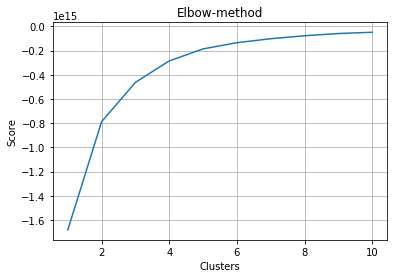

In [31]:
fig, ax = plt.subplots()
ax.plot([i+1 for i in range(k)],inertia)

ax.set(xlabel='Clusters', ylabel='Score',
       title='Elbow-method')
ax.grid()

A good choise of cluster is 4

In [32]:
dfFeClust = dfFe.dropna().copy()

In [33]:
len(dfFeClust)

9545

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(tokmean.values) #defaults to ‘k-means++’:
dfFeClust['Cluster'] = kmeans.labels_
kmeans.labels_

array([0, 3, 0, ..., 3, 1, 0], dtype=int32)

In [35]:
dfFeClust.head()

,Url,Price,Room,Surface,Bathroom,Floor,Cluster
0,https://www.immobiliare.it/69032803-Vendita-Bi...,169000.0,2,72.0,1,0,0
2,https://www.immobiliare.it/69783036-Vendita-At...,520000.0,4,120.0,3,12,3
4,https://www.immobiliare.it/60154116-Vendita-Mo...,195000.0,1,38.0,1,1,0
6,https://www.immobiliare.it/60679448-Vendita-Bi...,195000.0,2,60.0,1,1,0
8,https://www.immobiliare.it/70373906-Vendita-Tr...,279000.0,3,73.0,1,12,0


In [36]:
kmeansD = KMeans(n_clusters=4, random_state=0).fit(adjacency.values)

In [37]:
dfDe['Cluster'] = kmeansD.labels_
dfDe.head()

,Url,Descr,Cluster
0,https://www.immobiliare.it/69032803-Vendita-Bi...,Rif: 1653461 - CENTOCELLE in Via Tor de Schiav...,2
2,https://www.immobiliare.it/69783036-Vendita-At...,"Rif: VR/618 - Rifiutata proposta a €440,000 P...",2
4,https://www.immobiliare.it/60154116-Vendita-Mo...,"Il progetto ""Loft San Lorenzo"" crea un connubi...",2
6,https://www.immobiliare.it/60679448-Vendita-Bi...,"Elegante appartamento in palazzina in cortina,...",1
8,https://www.immobiliare.it/70373906-Vendita-Tr...,"Rif: 534-18 - ""VISITA SUBITO IL NOSTRO SITO WW...",2


For make easier the computation of the Jaccard Similarity (defined below) we create two dictionaries that contain which announcements belong to its cluster.

In [38]:
s = {}
for i in range(4):
    s[i] = list(dfDe.loc[dfDe.Cluster == i].index)
    

In [39]:
t = {}
for i in range(4):
    t[i] = list(dfFeClust.loc[dfFeClust.Cluster == i].index)


### Comparison among cluster
We expect that both datasets will lead to similar clusters. Is this true?

### Find similar clusters with Jaccard Similarity

$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$ defined as the intersection over union of two sets and it's used for comparing the similarity and diversity of sample sets.

In [40]:
#jaccard similarity is ratio between intersection and union

js = []

for i in range(4):
    for j in range(4):
        a = len(set(s[i]).intersection(set(t[j])))
        b = len(set(s[i]).union(set(t[j])))
        js.append((a/b, i, j))
        
js

[(0.08123407868666856, 0, 0),
 (0.006439742410303588, 0, 1),
 (0.0, 0, 2),
 (0.02708803611738149, 0, 3),
 (0.17677595628415302, 1, 0),
 (0.017716535433070866, 1, 1),
 (0.003612281757977122, 1, 2),
 (0.08526223263990625, 1, 3),
 (0.5347329083315014, 2, 0),
 (0.05550021346235947, 2, 1),
 (0.0048696648524778, 2, 2),
 (0.2290252511539506, 2, 3),
 (0.03617203076046711, 3, 0),
 (0.0110803324099723, 3, 1),
 (0.0, 3, 2),
 (0.011543394613082514, 3, 3)]

In [41]:
#3-most similar couples of clusters
sorted(js, reverse = True)[:3]

[(0.5347329083315014, 2, 0),
 (0.2290252511539506, 2, 3),
 (0.17677595628415302, 1, 0)]

### Word cloud of house descriptions
With the 3 most higher JS we want to create 3 wordcloud with the words that appear more frequently.

In [42]:
#first intersection
inter_1 = set(s[2]).intersection(set(t[0]))

#second intersection
inter_2 = set(s[2]).intersection(set(t[3]))

#third intersection
inter_3 = set(s[1]).intersection(set(t[0]))



In [43]:
#extract the descriptions
def cloud(inter):
    cloud = []

    for i in inter_1:
        cloud.append(dfDe["Descr"][i])
        
    cloud = str(cloud)
    
    return cloud

In [44]:
cloud_1 = cloud(inter_1)
cloud_2 = cloud(inter_2)
cloud_3 = cloud(inter_3)

In [50]:
ita = [word for word in stopwords]
stopwords = set(STOPWORDS)
stopwords.update(ita)
stopwords.update(["proponiamo", "vendita", "zona", "circa", "mq", "rif"])

In [52]:
#we want to give it the shape of a house
house_mask = np.array(Image.open("data/house.png"))

In [53]:
# Transform your mask into a new one
transformed_house_mask = np.ndarray((house_mask.shape[0],house_mask.shape[1]), np.int32)

for i in range(len(house_mask)):
    for j in range(len(house_mask[i])):
        if house_mask[i][j].any() == 0:
            transformed_house_mask[i][j] = 255
    
    

In [54]:
def wordcloud_fun(cloud):
    wc = WordCloud(background_color="white", max_words=1000, mask=transformed_house_mask,
               stopwords=stopwords, contour_width=3, contour_color='black')
    
    # Generate a wordcloud
    wc.generate(cloud)
    
    # show
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


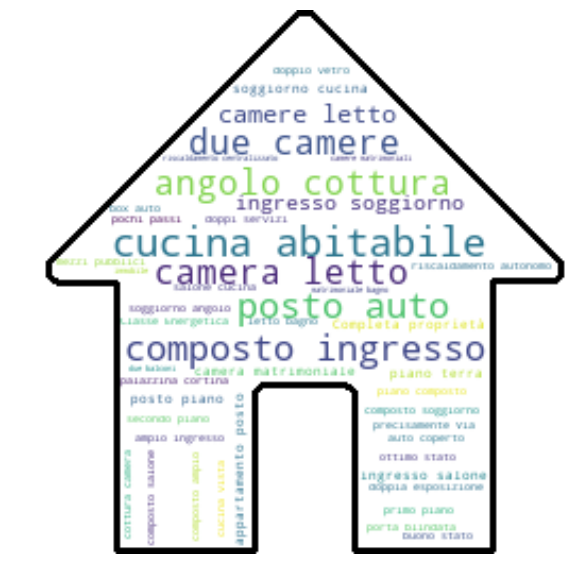

In [55]:
wordcloud_fun(cloud_1)

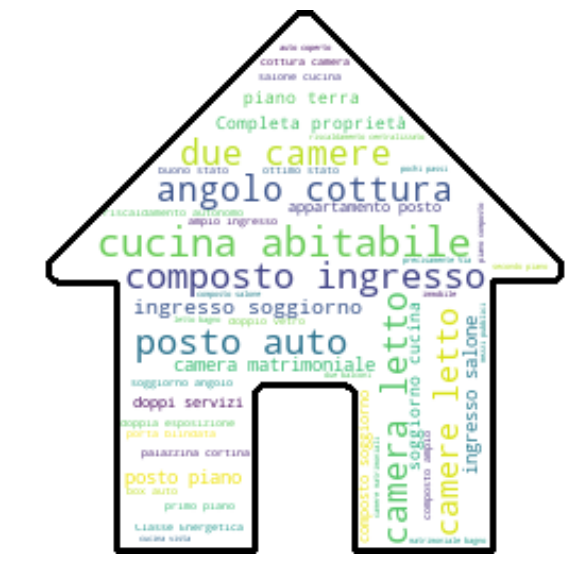

In [56]:
wordcloud_fun(cloud_2)

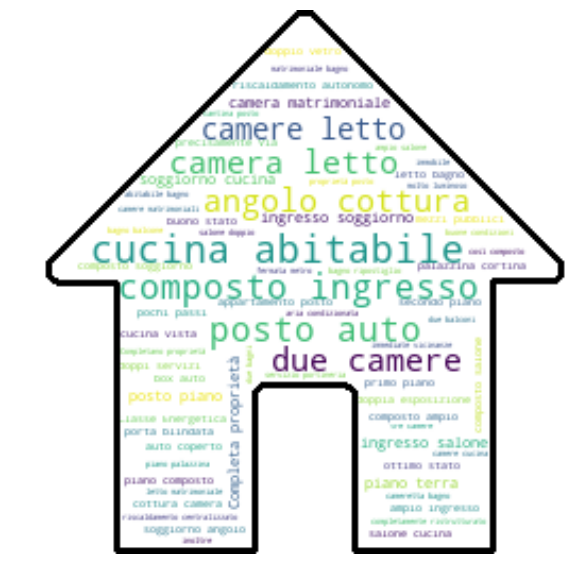

In [57]:
wordcloud_fun(cloud_3)

## Bonus 1

In the first bonus point to create our k-means function. To keep the code tidy, we decided to create a class in an external library called `libclust.py`.
To see how the library works, please open it in an editor (or [Github](https://github.com/MariaLuisaCroci/HW4-ADM/blob/master/libclust.py)). 
The library has been imported at the top, here is the result:

In [58]:
X = tokmean.values #Feautures values we want to k-means
k = 4 #Number of clusters
selfCluster = {}
myclust = libclust.KMeans(X, k) #Call of the function to make the clusters
selfCluster = myclust.giveCluster()

[46296.28795546559, 816859.6047619048, 123324.9174741784, 295698.0666695842]


For every cluster we want to see the dimension of it, so to compare it with the k-means++ computed with the `sklearn` library. 

In [59]:
dimClusts = {} 
for i in range(4):
    dimClusts[i] = len(selfCluster[i])
dimClusts

{0: 6916, 1: 42, 2: 2130, 3: 457}

In [60]:
dimClusts = {}
for i in range(4):
    dimClusts[i] = len(dfFeClust.loc[(dfFeClust['Cluster'] == i)])
dimClusts

{0: 6987, 1: 441, 2: 40, 3: 2077}

So as we can see, in the first block we have the k-means realized with our library, meanwhile in the second we have the k-means++ from `skilearn`. It's noticeable that the cluster are different but not so much, so overall we can consider ours as a good result.

## Bonus 2 

Now we want to do again the clustering, but this time with `pyspark` library. First we start by initializing the Spark environment:

In [61]:
findspark.init()
sc = pyspark.SparkContext.getOrCreate()

Then we initialize some variables and we pick some centroids at random:

In [62]:
k = 4
X = tokmean.values
centroids = np.empty([k, X.shape[1]])
for t,i in enumerate(np.random.choice(X.shape[0], k, replace=False)):
    centroids[t] = X[i]

centroids

array([[3.90e+05, 3.00e+00, 1.58e+02, 2.00e+00, 1.20e+01],
       [7.49e+05, 4.00e+00, 1.35e+02, 2.00e+00, 4.00e+00],
       [5.95e+05, 5.00e+00, 1.69e+02, 3.00e+00, 1.00e+00],
       [1.99e+05, 3.00e+00, 1.00e+02, 2.00e+00, 1.00e+00]])

After we create the function that maps every centroid to the closest cluster:

In [63]:
def kmeansMap(x):
    mindist = float("inf")
    mindistk = 0 
    for j in range(k):
        dist = np.linalg.norm(x-centroids[j])
        if(mindist > dist):
            mindist = dist
            mindistk = j
    
    return (mindistk, x) #(x, 1)

We pass the data to Spark, so it can be parallelized and ready to be executed.

In [64]:
l = sc.parallelize(X)

Now every time we want to execute the map function we wrote previously, then reduce the elements by key and compute the new centroids. If the new centroids are equals to the old ones, then we break the cycle and print the result.

In [68]:
for i in range(300):
    s = l.map(kmeansMap).groupByKey().mapValues(list).collect()
    
    oldcentroids = centroids.copy()
    for i,elem in enumerate(s):
        centroids[i] = np.mean(elem[1], axis=0)
        
    if(np.array_equal(centroids,oldcentroids)):
        print("Number of cycles: ",i, '\n')
        print("Clusters: ",str(s)[:800], '...', '\n')
        print("Centroids: ",centroids)
        break

Number of cycles:  3 

Clusters:  [(0, [array([5.2e+05, 4.0e+00, 1.2e+02, 3.0e+00, 1.2e+01]), array([4.8e+05, 5.0e+00, 1.2e+02, 2.0e+00, 2.0e+00]), array([6.9e+05, 5.0e+00, 2.1e+02, 3.0e+00, 2.0e+00]), array([9.80e+05, 5.00e+00, 2.35e+02, 3.00e+00, 1.00e+00]), array([4.45e+05, 3.00e+00, 9.00e+01, 1.00e+00, 2.00e+00]), array([7.80e+05, 4.00e+00, 1.55e+02, 2.00e+00, 2.00e+00]), array([6.50e+05, 4.00e+00, 1.25e+02, 2.00e+00, 4.00e+00]), array([9.95e+05, 5.00e+00, 1.90e+02, 2.00e+00, 1.00e+00]), array([4.70e+05, 5.00e+00, 1.35e+02, 2.00e+00, 4.00e+00]), array([8.49e+05, 4.00e+00, 1.60e+02, 2.00e+00, 1.00e+00]), array([5.99e+05, 5.00e+00, 1.72e+02, 2.00e+00, 4.00e+00]), array([6.49e+05, 4.00e+00, 1.60e+02, 2.00e+00, 6.00e+00]), array([6.49e+05, 5.00e+00, 1.60e+02, 3.00e+00, 3.00e+00]), array([8.9e+05, 5.0e+00, 2.3e+02, 3.0e+00, ... 

Centroids:  [[6.16470944e+05 4.17417840e+00 1.43988779e+02 2.05633803e+00
  3.42441315e+00]
 [4.08390476e+06 4.97619048e+00 3.79309524e+02 2.88095238e+00
  6.0